# Pass

In [1]:
#-------------------------------------------------------------
#--- ALL IMPORTS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- IMPORTING ESSENTIALS")
print("#-------------------------------------------------------------\n")

try:
    import monai
    import torch
    import itk
    import numpy as np
    import matplotlib.pyplot as plt
    import random
    import glob
    import os.path
    import tempfile
    from monai.transforms import LoadImage
    from monai.metrics import DiceMetric
    from torch.nn.functional import one_hot

    from utils import (
        preview_image,
        preview_3D_vector_field,
        preview_3D_deformation,
        jacobian_determinant,
        plot_against_epoch_numbers,
    )

except ImportError as e:
    print("Importing error:",e)

#-------------------------------------------------------------
#--- IMPORTING ESSENTIALS
#-------------------------------------------------------------



In [2]:
#-------------------------------------------------------------
#--- ASSIGNING DEVICE
#-------------------------------------------------------------

def get_device():
    print("#-------------------------------------------------------------")
    print("#--- ASSIGNING DEVICE")
    print("#-------------------------------------------------------------\n")

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("CUDA is available.")
        print("GPU:", torch.cuda.get_device_name(0)) # Prints the GPU name
    else:
        device = torch.device("cpu")
        print("CUDA not available. Using CPU.")
    print("Using device:", device)
    return device

# Implementation of the above function
device = get_device()

#-------------------------------------------------------------
#--- ASSIGNING DEVICE
#-------------------------------------------------------------

CUDA is available.
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Using device: cuda:0


In [3]:
#-------------------------------------------------------------
#--- CHECKING MONAI CONFIGURATION
#-------------------------------------------------------------

def configure_environment(seed=77):
    print("#-------------------------------------------------------------")
    print("#--- CHECKING MONAI CONFIGURATION")
    print("#-------------------------------------------------------------\n")

    # Set reproducibility
    monai.utils.set_determinism(seed=seed)
    print(f"Deterministic seed set to {seed}")

    # Disable ITK warnings
    itk.ProcessObject.SetGlobalWarningDisplay(False)
    # Disable TF32 for consistency
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    # Print MONAI config
    monai.config.print_config()

    # Enable inline plotting if in Jupyter
    try:
        get_ipython()
        from IPython import get_ipython
        get_ipython().run_line_magic("matplotlib", "inline")
        print("Notebook detected: Enabled %matplotlib inline")
    except Exception:
        pass

# Implementation of above function
configure_environment()

#-------------------------------------------------------------
#--- CHECKING MONAI CONFIGURATION
#-------------------------------------------------------------

Deterministic seed set to 77
MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.7.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\OneDrive\Desktop\Feri_Choreko\uwhaa\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.2.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.22.1+cu118
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT 

In [4]:
#-------------------------------------------------------------
#--- ASSIGNING PATHS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- ASSIGNING PATHS")
print("#-------------------------------------------------------------\n")

directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)

root_dir = r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root"
os.makedirs(root_dir, exist_ok=True)  
print(f"Root directory: {root_dir}")

segmentation_path_expression = "IBSR_Mask/IBSR_*_segTRI_fill_ana.nii"
image_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_*_ana_strip.nii")
segmentation_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_*_segTRI_fill_ana.nii")

print(image_paths)
print(len(image_paths),"\n")

print(segmentation_paths)
print(len(segmentation_paths),"\n")

#-------------------------------------------------------------
#--- ASSIGNING PATHS
#-------------------------------------------------------------

Root directory: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root
['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_05_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_06_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_07_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_08_an

In [5]:
#-------------------------------------------------------------
#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS")
print("#-------------------------------------------------------------\n")

resize = 128
num_segmentation_classes = 4  # background, CSF, white matter, gray matter
# Pretend that only a few segmentations are available
num_segs_to_select = 18
np.random.shuffle(segmentation_paths)
segmentation_paths = segmentation_paths[:num_segs_to_select]
print(segmentation_paths)
print(len(segmentation_paths),"\n")

#-------------------------------------------------------------
#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS
#-------------------------------------------------------------

['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_14_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_18_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_11_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_13_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_16_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR

In [6]:
#-------------------------------------------------------------
#--- EXTRACTING IDs
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- EXTRACTING IDs HAVING BOTH IMG AND SEG")
print("#-------------------------------------------------------------\n")

# Function to extract the image ID from the file path
def path_to_id(path):
    return "_".join(os.path.basename(path).split("_")[:2])

seg_ids = list(map(path_to_id, segmentation_paths))
print(seg_ids,"\n")

# Creates a lazy map object, meaning it holds the instructions to apply path_to_id() but hasn’t executed them yet.
img_ids = map(path_to_id, image_paths)
print(img_ids,"\n")     # This just prints the object’s memory address, not the content:

# TO SEE THE ACTUAL IDs UNCOMMENT THIS
'''
img_ids = list(map(path_to_id, image_paths))
print(img_ids)
'''

#-------------------------------------------------------------
#--- EXTRACTING IDs HAVING BOTH IMG AND SEG
#-------------------------------------------------------------

['IBSR_14', 'IBSR_18', 'IBSR_02', 'IBSR_11', 'IBSR_03', 'IBSR_13', 'IBSR_16', 'IBSR_05', 'IBSR_07', 'IBSR_15', 'IBSR_04', 'IBSR_17', 'IBSR_08', 'IBSR_10', 'IBSR_01', 'IBSR_09', 'IBSR_06', 'IBSR_12'] 




'\nimg_ids = list(map(path_to_id, image_paths))\nprint(img_ids)\n'

In [7]:
#-------------------------------------------------------------
#--- CHOOSING THE SPLIT
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHOOSING THE SPLIT")
print("#-------------------------------------------------------------\n")

data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]} # Create a dictionary with the image file path
    if img_id in seg_ids: # Check if this image has a corresponding segmentation file
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)] # Add segmentation file path to the dictionary
    data.append(data_item) # Add this dictionary to the data list

print(data)
print(len(data),"\n")

# Filters data to keep only entries that contain a segmentation path.
data_seg_available = list(filter(lambda d: "seg" in d.keys(), data))

# Filters data to keep entries that only have an image (no "seg" key).
data_seg_unavailable = list(filter(lambda d: "seg" not in d.keys(), data))

# Splits data_seg_available into:
# 80% for training
# 20% for validation
data_seg_available_train, data_seg_available_valid = monai.data.utils.partition_dataset(
    data_seg_available, ratios=(8, 2) # 80/20
)
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

print(f"Number of data items with segmentation labels: {len(data_seg_available)}")
print(f"Number of data items with segmentation labels for training: {len(data_seg_available_train)}")
print(f"Number of data items with segmentation labels for validation: {len(data_seg_available_valid)}")
print(f"Number of data items without segmentation labels: {len(data_seg_unavailable)}")

print(data_seg_available_train)
print(data_seg_available_valid)
print(data_seg_unavailable)

#-------------------------------------------------------------
#--- CHOOSING THE SPLIT
#-------------------------------------------------------------

[{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_01_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_M

In [8]:
#-------------------------------------------------------------
#--- STUDING DATA
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- STUDYING DATA")
print("#-------------------------------------------------------------\n")

from monai.transforms import LoadImage
import torch

# Initialize the loader
loader = LoadImage(image_only=True)

# Loop over each item in your data list
for idx, item in enumerate(data):
    print(f"\nData index: {idx}")

    # Load and print the shape of the image
    img_tensor = loader(item["img"])
    print(f"Image path: {item['img']}")
    print(f"Image shape (torch tensor): {img_tensor.shape}")

    # Load and print the shape of the segmentation if it exists
    if "seg" in item:
        seg_tensor = loader(item["seg"])
        print(f"Segmentation path: {item['seg']}")
        print(f"Segmentation shape (torch tensor): {seg_tensor.shape}")



#-------------------------------------------------------------
#--- STUDYING DATA
#-------------------------------------------------------------


Data index: 0
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_01_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 1
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_02_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_02_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 2
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_03_ana_strip.nii
Image shape (torch tensor): torch.Si


#-------------------------------------------------------------
#--- VISUALIZING DATA
#-------------------------------------------------------------



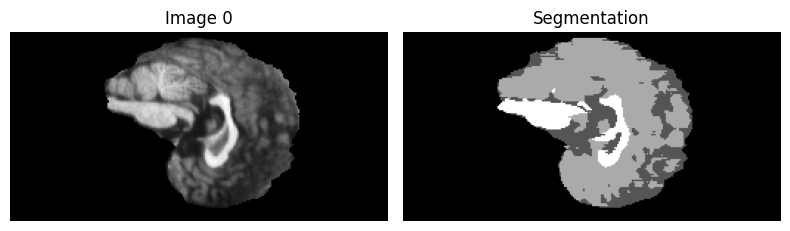

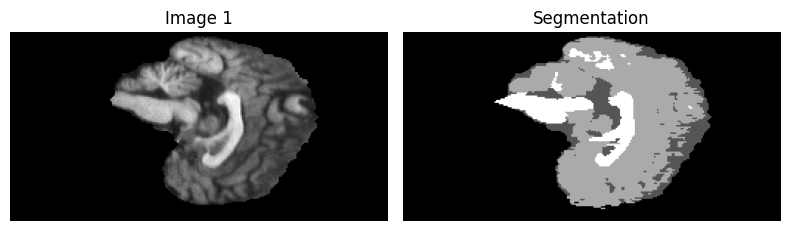

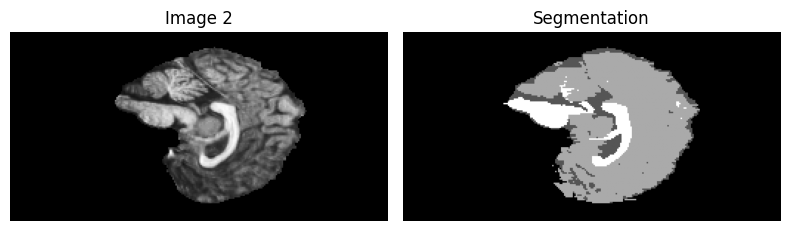

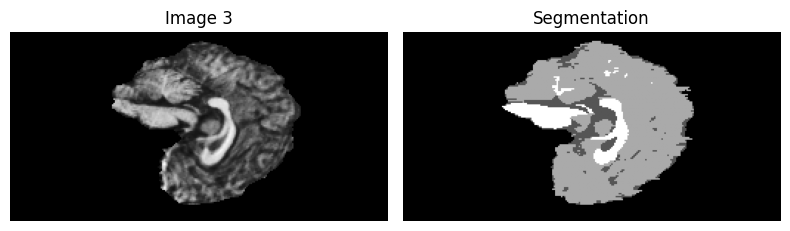

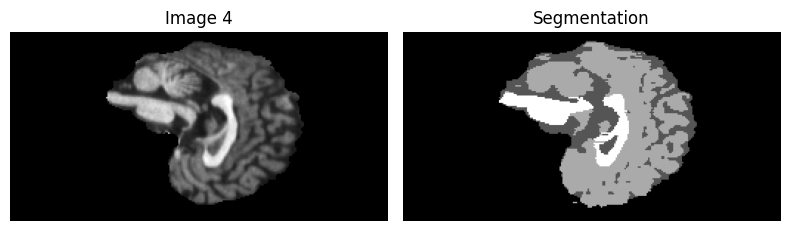

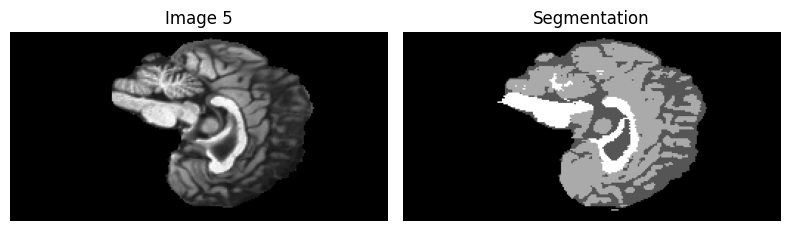

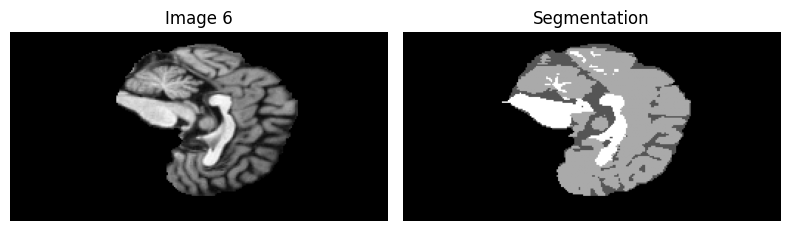

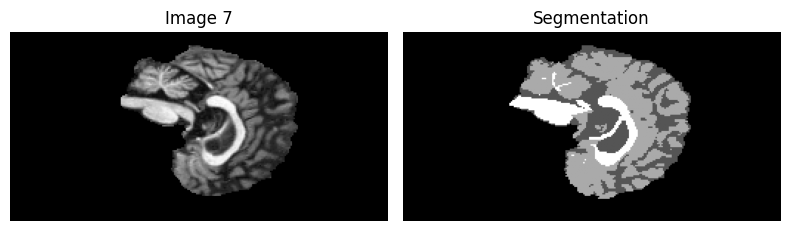

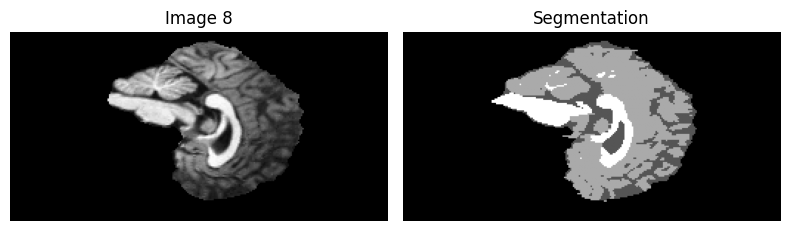

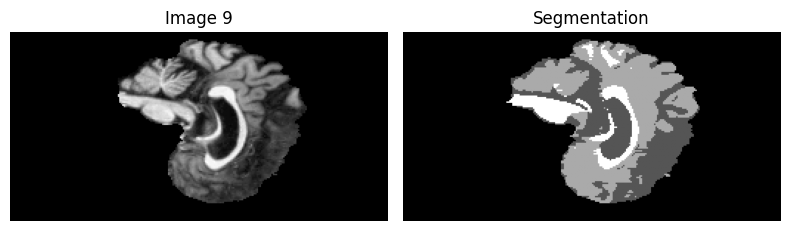

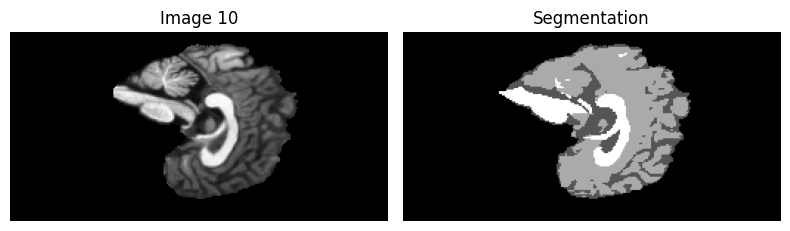

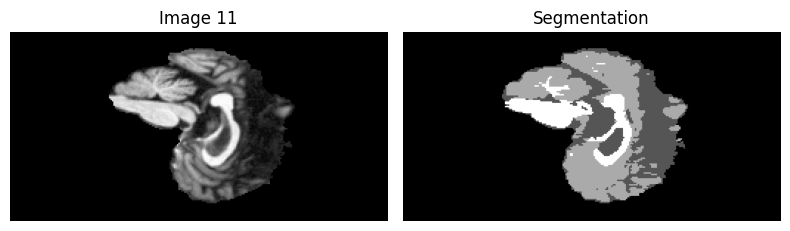

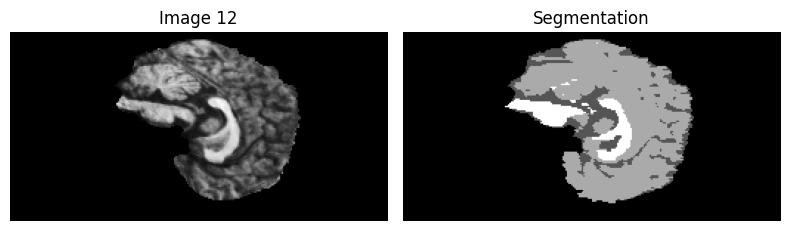

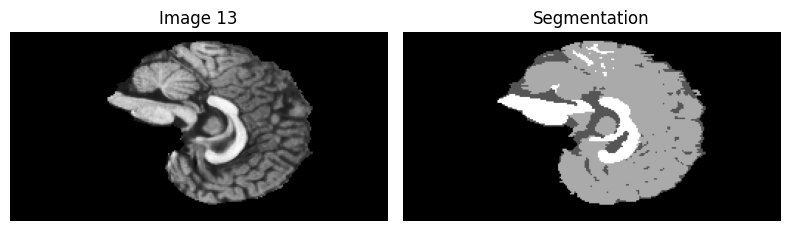

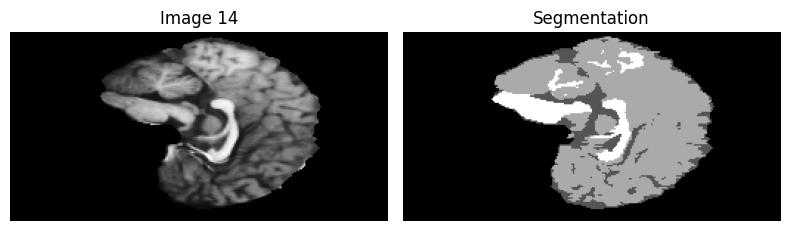

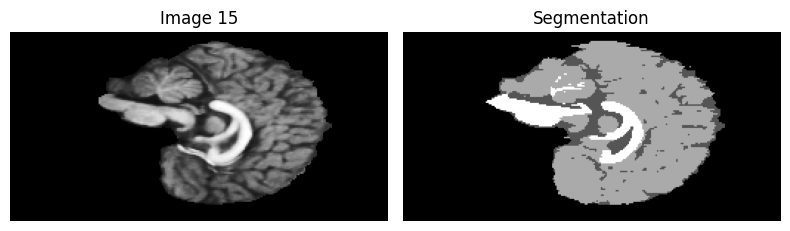

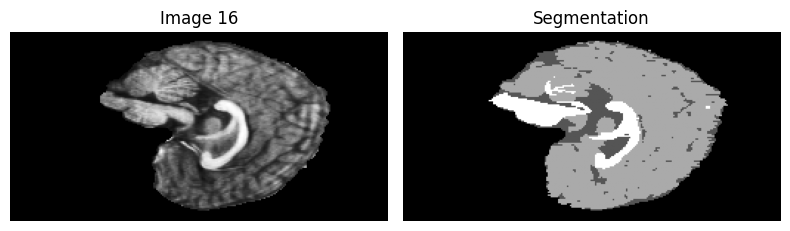

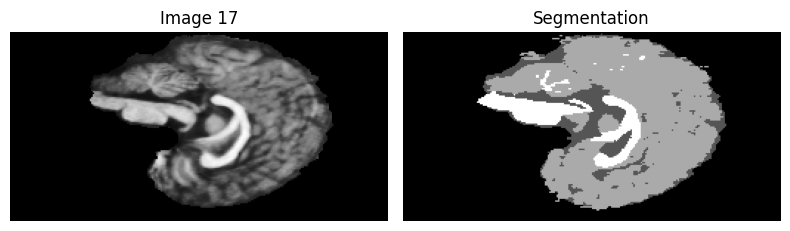

In [9]:
#-------------------------------------------------------------
#--- VISUALIZING DATA
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- VISUALIZING DATA")
print("#-------------------------------------------------------------\n")

import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Loader to convert filepath to array
loader = LoadImage(image_only=True)

for i, item in enumerate(data):
    img = loader(item["img"])
    
    has_seg = "seg" in item
    fig, axs = plt.subplots(1, 2 if has_seg else 1, figsize=(8, 4))
    
    # Ensure axs is always a list for uniform access
    if not has_seg:
        axs = [axs]
    
    # Display the image (middle slice)
    axs[0].imshow(img[img.shape[0] // 2], cmap='gray')
    axs[0].set_title(f"Image {i}")
    axs[0].axis('off')

    # If segmentation exists, display it too
    if has_seg:
        seg = loader(item["seg"])
        axs[1].imshow(seg[seg.shape[0] // 2], cmap='gray')
        axs[1].set_title("Segmentation")
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()



#-------------------------------------------------------------
#--- DISPLAYING RANDOM IMAGE
#-------------------------------------------------------------



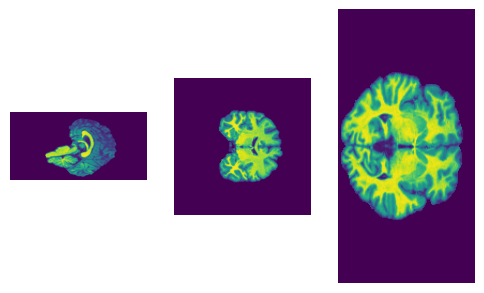

In [10]:
#-------------------------------------------------------------
#--- DISPLAYING RANDOM IMAGE
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DISPLAYING RANDOM IMAGE")
print("#-------------------------------------------------------------\n")

data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

In [11]:
#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- APPLYING PREPROCESSING TRANSFORMATION")
print("#-------------------------------------------------------------\n")

# Define patch size and number of samples
patch_size = (96, 96, 96)
num_samples = 1

# set of preprocessing transformations
transform_seg_available_t = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=(resize, resize, resize),
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
                # 👇 Foreground-aware 3D patch extraction
        monai.transforms.RandCropByPosNegLabeld(
            keys=["img", "seg"],
            label_key="seg",
            spatial_size=patch_size,
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="img",
        ),
    ]
)

# set of preprocessing transformations
transform_seg_available_v = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=(resize, resize, resize),
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

print(resize)

dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train, transform=transform_seg_available_t, cache_num=4 # 16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid, transform=transform_seg_available_v, cache_num=4 # 16
)


#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

128


Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]



#-------------------------------------------------------------
#--- PREVIEW RANDOM IMAGE
#-------------------------------------------------------------



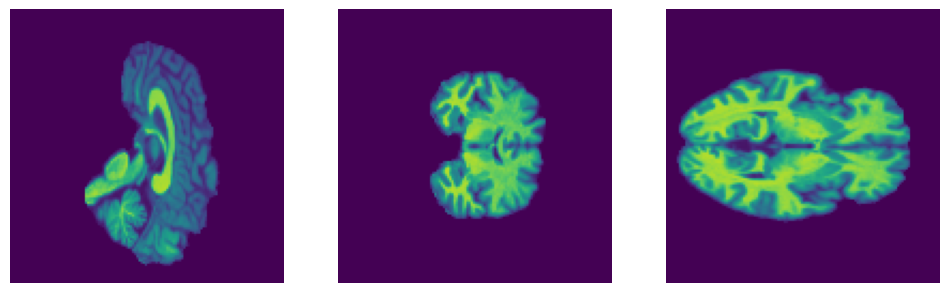

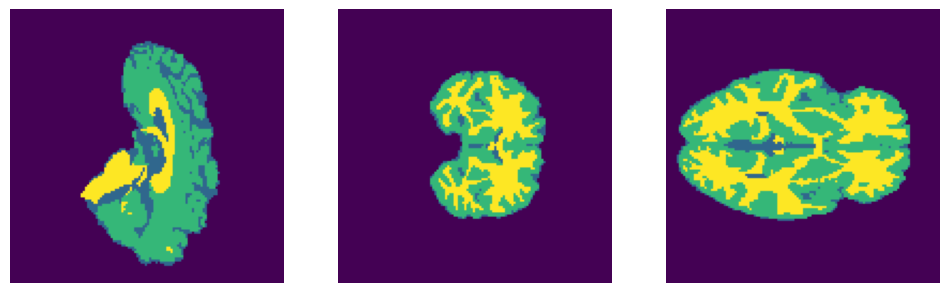

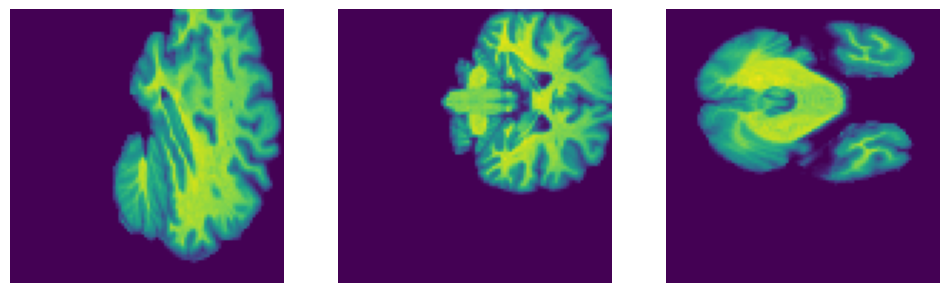

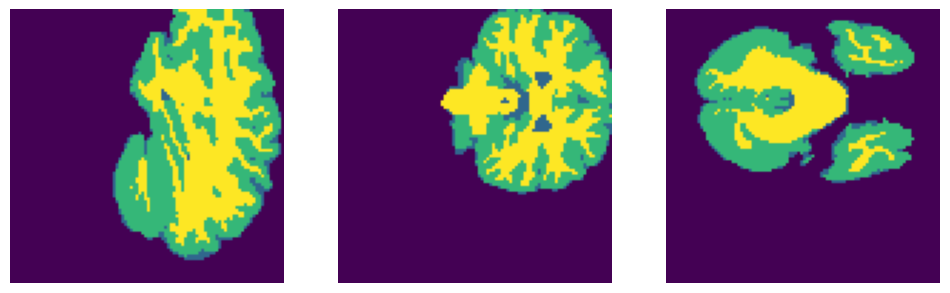

In [12]:
#-------------------------------------------------------------
#--- PREVIEW RANDOM IMAGE
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- PREVIEW RANDOM IMAGE")
print("#-------------------------------------------------------------\n")


data_item = transform_seg_available_v(random.choice(data_seg_available))

preview_image(data_item['img'][0])
preview_image(data_item['seg'][0])

# THIS IS FOR TRAIN USING PATCH BASED

data_item_list = transform_seg_available_t(random.choice(data_seg_available))  
# data_item_list is a list of dicts, each dict has 'img' and 'seg'

# Pick the first patch dict
patch0 = data_item_list[0]

# patch0 is a dict, so now you can access 'img' and 'seg'
img_patch = patch0['img']  # tensor shape: (1, 96, 96, 96)
seg_patch = patch0['seg']

# remove channel dim
img_patch = img_patch[0]  # shape: (96, 96, 96)
seg_patch = seg_patch[0]

# pick middle slice
z = img_patch.shape[0] // 2

# preview slice
preview_image(img_patch)
preview_image(seg_patch)


In [ ]:
#-------------------------------------------------------------
#--- CHECKING THE SHAPE OF LOADED SEG MASK
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- CHECKING THE SHAPE OF LOADED SEG MASK")
print("#-------------------------------------------------------------\n")

from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_seg_available_train)
print("-----------------------------------------------")
print_all_seg_shapes(data_seg_available_valid)


#-------------------------------------------------------------
#--- CHECKING THE SHAPE OF LOADED SEG MASK
#-------------------------------------------------------------

Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])
Item 3: seg shape = torch.Size([256, 128, 256, 1])
Item 4: seg shape = torch.Size([256, 128, 256, 1])
Item 5: seg shape = torch.Size([256, 128, 256, 1])
Item 6: seg shape = torch.Size([256, 128, 256, 1])
Item 7: seg shape = torch.Size([256, 128, 256, 1])
Item 8: seg shape = torch.Size([256, 128, 256, 1])
Item 9: seg shape = torch.Size([256, 128, 256, 1])
Item 10: seg shape = torch.Size([256, 128, 256, 1])
Item 11: seg shape = torch.Size([256, 128, 256, 1])
Item 12: seg shape = torch.Size([256, 128, 256, 1])
Item 13: seg shape = torch.Size([256, 128, 256, 1])
-----------------------------------------------
Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg 

In [14]:
#-------------------------------------------------------------
#--- DEFINING SEG NET
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DEFINING SEG NET")
print("#-------------------------------------------------------------\n")

from monai.networks.nets import VNet

seg_net = VNet(
    spatial_dims=3, 
    in_channels=1, 
    out_channels=4, 
    act=('leakyrelu', {'negative_slope': 0.01, 'inplace': True}), 
    dropout_prob=0, 
    dropout_prob_down=0.3, 
    dropout_prob_up=(0.0, 0.3), 
    dropout_dim=3, 
    bias=False
)




#-------------------------------------------------------------
#--- DEFINING SEG NET
#-------------------------------------------------------------



monai.networks.nets.vnet VNet.__init__:dropout_prob: Argument `dropout_prob` has been deprecated since version 1.2. please use `dropout_prob_down` instead.
monai.networks.nets.vnet VNet.__init__:dropout_prob: Argument `dropout_prob` has been deprecated since version 1.2. please use `dropout_prob_up` instead.


In [15]:
! pip install torchinfo

from torchinfo import summary
import torch

# Assuming your model is named seg_net and input shape is (batch_size, channels, D, H, W)
input_size = (1, 1, 96, 96, 96)  # example input shape, adjust patch size as per your data

summary(seg_net, input_size=input_size, device="cpu")  # or "cuda" if model on GPU


Layer (type:depth-idx)                             Output Shape              Param #
VNet                                               [1, 4, 96, 96, 96]        --
├─InputTransition: 1-1                             [1, 16, 96, 96, 96]       --
│    └─Convolution: 2-1                            [1, 16, 96, 96, 96]       --
│    │    └─Conv3d: 3-1                            [1, 16, 96, 96, 96]       2,000
│    │    └─ADN: 3-2                               [1, 16, 96, 96, 96]       32
│    └─LeakyReLU: 2-2                              [1, 16, 96, 96, 96]       --
├─DownTransition: 1-2                              [1, 32, 48, 48, 48]       --
│    └─Conv3d: 2-3                                 [1, 32, 48, 48, 48]       4,096
│    └─BatchNorm3d: 2-4                            [1, 32, 48, 48, 48]       64
│    └─LeakyReLU: 2-5                              [1, 32, 48, 48, 48]       --
│    └─Sequential: 2-6                             [1, 32, 48, 48, 48]       --
│    │    └─LUConv: 3-3      

In [16]:
#-------------------------------------------------------------
#--- COMPUTING FORWARD PASS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- COMPUTING FORWARD PASS")
print("#-------------------------------------------------------------\n")

'''
# Picking one patch from the list first
data_item_list = random.choice(dataset_seg_available_train)  # this is a list
data_item = data_item_list[0]  # pick first patch dict
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

import torch.nn.functional as F
# Convert to one-hot: shape [1, 96, 96, 96, 4]
one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)
# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]
one_hot = one_hot.permute(0, 4, 1, 2, 3)
print(f"Shape of one hot ground truth label: {one_hot.shape}")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Ground truth label: {data_item['seg']}")
print(f"Seg output:{seg_net_example_output}")
print(f"One hot: {one_hot}")
'''


# Process all patches:
data_item_list = random.choice(dataset_seg_available_train)

for data_item in data_item_list:
    seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
    print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")

    print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
    print(f"Shape of seg_net output: {seg_net_example_output.shape}")

    import torch.nn.functional as F
    one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)
    one_hot = one_hot.permute(0, 4, 1, 2, 3)
    print(f"Shape of one hot ground truth label: {one_hot.shape}")

'''
data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")

print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

import torch.nn.functional as F
# Convert to one-hot: shape [1, 96, 96, 96, 4]
one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)

# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]
one_hot = one_hot.permute(0, 4, 1, 2, 3)
print(f"Shape of one hot ground truth label: {one_hot.shape}")

print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Ground truth label: {data_item['seg']}")
print(f"Seg output:{seg_net_example_output}")
print(f"One hot: {one_hot}")
'''

#-------------------------------------------------------------
#--- COMPUTING FORWARD PASS
#-------------------------------------------------------------

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 96, 96, 96])
Shape of seg_net output: torch.Size([1, 4, 96, 96, 96])
Shape of one hot ground truth label: torch.Size([1, 4, 96, 96, 96])


'\ndata_item = random.choice(dataset_seg_available_train)\nseg_net_example_output = seg_net(data_item["img"].unsqueeze(0))\nprint(f"Segmentation classes: {torch.unique(data_item[\'seg\']).as_tensor()}")\n\nprint(f"Shape of ground truth label: {data_item[\'seg\'].unsqueeze(0).shape}")\nprint(f"Shape of seg_net output: {seg_net_example_output.shape}")\n\nimport torch.nn.functional as F\n# Convert to one-hot: shape [1, 96, 96, 96, 4]\none_hot = F.one_hot(data_item[\'seg\'].long(), num_classes=4)\n\n# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]\none_hot = one_hot.permute(0, 4, 1, 2, 3)\nprint(f"Shape of one hot ground truth label: {one_hot.shape}")\n\nprint("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")\nprint(f"Ground truth label: {data_item[\'seg\']}")\nprint(f"Seg output:{seg_net_example_output}")\nprint(f"One hot: {one_hot}")\n'

In [17]:
#-------------------------------------------------------------
#--- DEFINING VARIOUS LOSSES
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- DEFINING VARIOUS LOSSES")
print("#-------------------------------------------------------------\n")

dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean",
)

dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False, 
    softmax=False, 
    reduction="mean",
)

dice_metric = DiceMetric(
    include_background=True,
    reduction="none",   # No reduction → get individual class scores
    get_not_nans=True   # Ensures proper averaging when some classes are missing
    )

dice_metric2 = DiceMetric(
    include_background=True,
    reduction="mean",   # mean over batch and classes, change to "none" if you want per-class
    get_not_nans=True
)

#-------------------------------------------------------------
#--- DEFINING VARIOUS LOSSES
#-------------------------------------------------------------



In [18]:
#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- INITIALIZING DATALOADER")
print("#-------------------------------------------------------------\n")

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train, batch_size=4, num_workers=0, shuffle=True #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 8
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid, batch_size=4, num_workers=0, shuffle=False #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 16
)

#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------



In [19]:
#-------------------------------------------------------------
#--- SEG NET WITH DSC
#-------------------------------------------------------------
from monai.networks.utils import one_hot

print("#-------------------------------------------------------------")
print("#--- SEG NET WITH DSC")
print("#-------------------------------------------------------------\n")

# Set up dataloaders

# Training cell
# (if already done then you may skip to and uncomment the checkpoint loading cell below)

seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)
num_classes = 4
max_epochs = 5 # 60
training_losses = []
training_dices = []
validation_losses = []
validation_dices = []
val_interval = 1

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)
        # print(true_segs.shape)
        # print(imgs.shape)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # --- Dice Metric ---
        pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_classes)
        true_onehot = one_hot(true_segs.unsqueeze(1), num_classes=num_classes)
        dice_metric(pred_onehot, true_onehot)  # accumulate batch-wise metrics

    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])
    
    # After training loop: aggregate and reset DSC
    dice_scores, _ = dice_metric.aggregate()
    dice_metric.reset()
    # Compute average DSC across all samples and classes
    # First flatten to [N] and then take mean
    training_dice = dice_scores.mean().item()
    print(f"\ttraining DSC: {training_dice:.4f}")
    training_dices.append([epoch_number, training_dice])

    if epoch_number % val_interval == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

                # --- Dice Metric ---
                print(f"pred: {predicted_segs.shape} true: {true_segs.shape}")

                pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_classes)
                true_onehot = one_hot(true_segs, num_classes=num_classes)
                print(f"pred hot: {pred_onehot.shape} true hot: {true_onehot.shape}")

                dice_metric(pred_onehot, true_onehot)
                # accumulate batch-wise metrics                

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])

        # After training loop: aggregate and reset DSC
        dice_scores, _ = dice_metric.aggregate()
        dice_metric.reset()
        validation_dice = dice_scores.mean().item()
        print(f"\tvalidation DSC: {validation_dice:.4f}")
        validation_dices.append([epoch_number, validation_dice])

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

#-------------------------------------------------------------
#--- SEG NET WITH DSC
#-------------------------------------------------------------

Epoch 1/5:
	training loss: 0.8018581420183182
	training DSC: 0.1191
pred: torch.Size([4, 4, 128, 128, 128]) true: torch.Size([4, 1, 128, 128, 128])
pred hot: torch.Size([4, 4, 128, 128, 128]) true hot: torch.Size([4, 4, 128, 128, 128])
	validation loss: 0.924228847026825
	validation DSC: 0.0582
Epoch 2/5:
	training loss: 0.7892133593559265
	training DSC: 0.1464
pred: torch.Size([4, 4, 128, 128, 128]) true: torch.Size([4, 1, 128, 128, 128])
pred hot: torch.Size([4, 4, 128, 128, 128]) true hot: torch.Size([4, 4, 128, 128, 128])
	validation loss: 0.8004038333892822
	validation DSC: 0.1922
Epoch 3/5:
	training loss: 0.7851229012012482
	training DSC: 0.1462
pred: torch.Size([4, 4, 128, 128, 128]) true: torch.Size([4, 1, 128, 128, 128])
pred hot: torch.Size([4, 4, 128, 128, 128]) true hot: torch.Size([4, 4, 128, 128, 128])
	validation loss: 0.80

#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION LOSS
#-------------------------------------------------------------



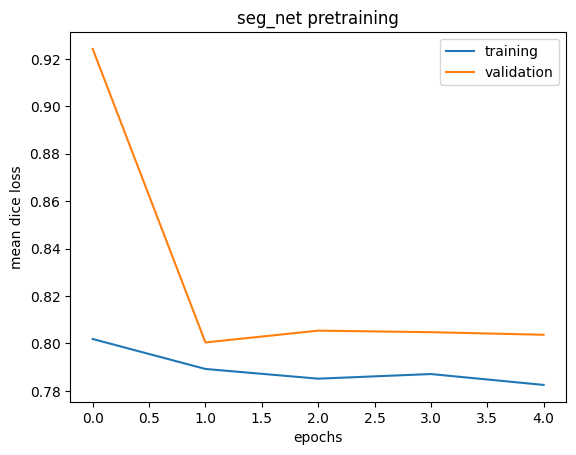

In [20]:
#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION LOSS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PLOTTING TRAINING AND VALIDATION LOSS")
print("#-------------------------------------------------------------\n")

# Plot the training and validation losses
plot_against_epoch_numbers(training_losses, label="training")
plot_against_epoch_numbers(validation_losses, label="validation")
plt.legend()
plt.ylabel("mean dice loss")
plt.title("seg_net pretraining")
plt.savefig("seg_net_pretrained_losses.png")
plt.show()

In [21]:
TRAVELLER YOUR JOURNEY ENDS HERE

SyntaxError: invalid syntax (245876232.py, line 1)

In [ ]:
#-------------------------------------------------------------
#--- CHECKPOINT SAVE FOR SEG NET
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKPOINT SAVE FOR SEG NET")
print("#-------------------------------------------------------------\n")

torch.save(seg_net.state_dict(), "seg_net_pretrained.pth")

#-------------------------------------------------------------
#--- CHECKPOINT SAVE FOR SEG NET
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- CHECKPOINT LOAD IF NECESSARY
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKPOINT LOAD IF NECESSARY")
print("#-------------------------------------------------------------\n")

# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net_pretrained.pth', weights_only=True))

#-------------------------------------------------------------
#--- CHECKPOINT LOAD IF NECESSARY
#-------------------------------------------------------------



#-------------------------------------------------------------
#--- TRYING OUT SEGNET ON RANDOM VALIDATION
#-------------------------------------------------------------

Original image from validation set:


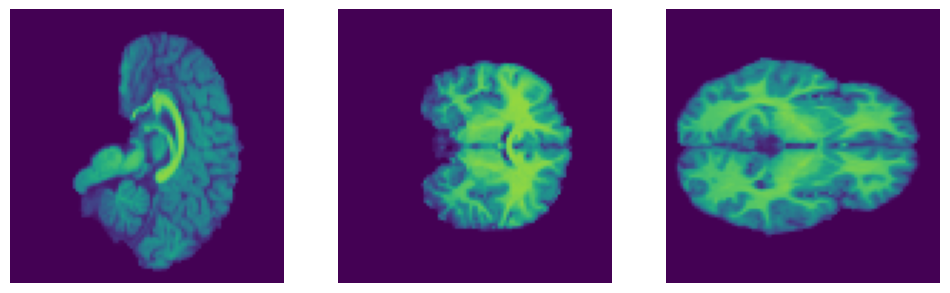

Ground truth segmentation:


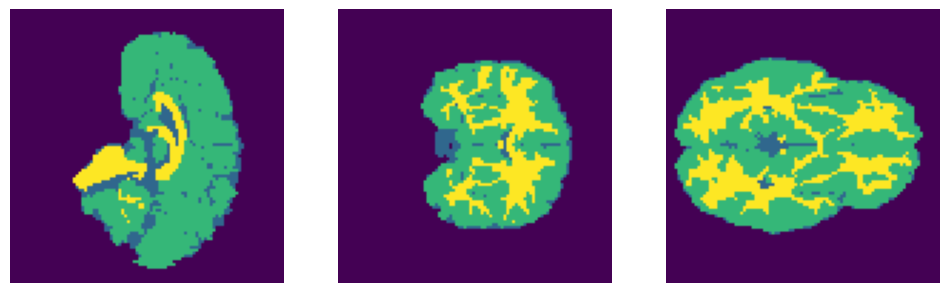

Our predicted segmentation:


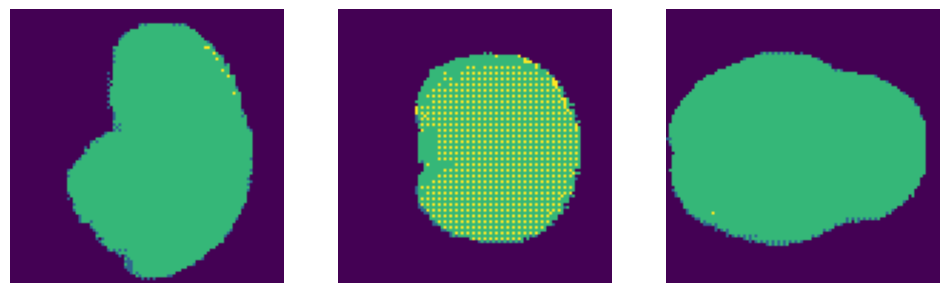

In [ ]:
#-------------------------------------------------------------
#--- TRYING OUT SEGNET ON RANDOM VALIDATION
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- TRYING OUT SEGNET ON RANDOM VALIDATION")
print("#-------------------------------------------------------------\n")

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])

del test_seg_predicted
torch.cuda.empty_cache()

In [ ]:
#-------------------------------------------------------------
#--- SPLITTING DATA FOR COMBINED MODELS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- SPLITTING DATA FOR COMBINED MODELS")
print("#-------------------------------------------------------------\n")

data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order

data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, ratios=(2, 8), shuffle=False  # 20% VALID AND 80% TRAIN
)

#-------------------------------------------------------------
#--- SPLITTING DATA FOR COMBINED MODELS
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- CREATING ALL POSSIBLE PAIRS OF IMAGES AND THEIR AVAILABLE CORRESPONDING SEGMENTATIONS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CREATING ALL POSSIBLE PAIRS OF IMAGES AND THEIR AVAILABLE CORRESPONDING SEGMENTATIONS")
print("#-------------------------------------------------------------\n")

def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {"img1": d1["img"], "img2": d2["img"]}
            if "seg" in d1.keys():
                pair["seg1"] = d1["seg"]
            if "seg" in d2.keys():
                pair["seg2"] = d2["seg"]
            data_pairs.append(pair)
    return data_pairs

data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

#-------------------------------------------------------------
#--- CREATING ALL POSSIBLE PAIRS OF IMAGES AND THEIR AVAILABLE CORRESPONDING SEGMENTATIONS
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- PRINTING ABOVE DATA PAIRS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PRINTING ABOVE DATA PAIRS")
print("#-------------------------------------------------------------\n")

def print_data_pairs(data_pairs, max_print=5):
    print(f"Total pairs: {len(data_pairs)}\n")
    for i, pair in enumerate(data_pairs):
        if i >= max_print:
            print(f"... and {len(data_pairs) - max_print} more pairs.")
            break
        print(f"Pair {i + 1}:")
        print(f"  img1: {pair.get('img1')}")
        print(f"  img2: {pair.get('img2')}")
        if 'seg1' in pair:
            print(f"  seg1: {pair['seg1']}")
        if 'seg2' in pair:
            print(f"  seg2: {pair['seg2']}")
        print()

print("Validation Data Pairs:")
print_data_pairs(data_pairs_valid)

print("\nTraining Data Pairs:")
print_data_pairs(data_pairs_train)


#-------------------------------------------------------------
#--- PRINTING ABOVE DATA PAIRS
#-------------------------------------------------------------

Validation Data Pairs:
Total pairs: 6

Pair 1:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii

Pair 2:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii

Pair 3:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii

Pair 4:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii


In [ ]:
#-------------------------------------------------------------
#--- CATEGORIZING A LIST OF IMAGE PAIRS INTO FOUR GROUPS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CATEGORIZING A LIST OF IMAGE PAIRS INTO FOUR GROUPS")
print("#-------------------------------------------------------------\n")

def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {"00": [], "01": [], "10": [], "11": []}
    for d in data_pairs_list:
        if "seg1" in d.keys() and "seg2" in d.keys():
            out_dict["11"].append(d)
        elif "seg1" in d.keys():
            out_dict["10"].append(d)
        elif "seg2" in d.keys():
            out_dict["01"].append(d)
        else:
            out_dict["00"].append(d)
    return out_dict

data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

# Print each group on a new line
print("Training Pairs Subdivided:")
for key, value in data_pairs_train_subdivided.items():
    print(f"{key}: {len(value)} pairs")

print(data_pairs_train_subdivided, "\n")
print(data_pairs_valid_subdivided, "\n")

#-------------------------------------------------------------
#--- CATEGORIZING A LIST OF IMAGE PAIRS INTO FOUR GROUPS
#-------------------------------------------------------------

Training Pairs Subdivided:
00: 20 pairs
01: 40 pairs
10: 40 pairs
11: 56 pairs
{'00': [{'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_10_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_12_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_10_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_13_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_10_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_17_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Im

In [ ]:
#-------------------------------------------------------------
#--- CHECKING ABOVE GROUPS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKING ABOVE GROUPS")
print("#-------------------------------------------------------------\n")

def print_subdivided_data_pairs(data_dict, title="Data Pairs Subdivided"):
    print(title)
    for key in sorted(data_dict.keys()):
        print(f"\nCategory '{key}' - Total: {len(data_dict[key])}")
        for i, pair in enumerate(data_dict[key], 1):
            print(f"  Pair {i}:")
            for k, v in pair.items():
                print(f"    {k}: {v}")
        if len(data_dict[key]) == 0:
            print("    (No pairs)")

print_subdivided_data_pairs(data_pairs_train_subdivided, "Training Data Pairs Subdivided")
print("\n" + "="*40 + "\n")
print_subdivided_data_pairs(data_pairs_valid_subdivided, "Validation Data Pairs Subdivided")


#-------------------------------------------------------------
#--- CHECKING ABOVE GROUPS
#-------------------------------------------------------------

Training Data Pairs Subdivided

Category '00' - Total: 20
  Pair 1:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_10_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_12_ana_strip.nii
  Pair 2:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_10_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii
  Pair 3:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_10_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_17_ana_strip.nii
  Pair 4:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_10_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_

In [ ]:
#-------------------------------------------------------------
#--- CATEGORY INFO
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CATEGORY INFO")
print("#-------------------------------------------------------------\n")

# print some useful counts to be aware of
num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = (
    len(data_pairs_train_subdivided["01"])
    + len(data_pairs_train_subdivided["10"])
    + len(data_pairs_train_subdivided["11"])
)

print(f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone.""")
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

#-------------------------------------------------------------
#--- CATEGORY INFO
#-------------------------------------------------------------

We have 136 pairs to train reg_net and seg_net together,
  and an additional 20 to train reg_net alone.
We have 6 pairs for reg_net validation.


In [ ]:
#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- APPLYING PREPROCESSING TRANSFORMATION")
print("#-------------------------------------------------------------\n")

def unsqueeze_if_needed(x):
    # Squeeze last dim if it's singleton channel dim
    if x.ndim == 3:
        return x.unsqueeze(3)
    return x

transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=["img1", "seg1", "img2", "seg2"], image_only=True, allow_missing_keys=True),
        monai.transforms.LambdaD(keys=["img1", "seg1", "img2", "seg2"], func=unsqueeze_if_needed, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=["img1", "seg1", "img2", "seg2"], indices=(3,2, 1, 0), allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=["img1", "img2"], name="img12", dim=0),
        monai.transforms.DeleteItemsD(keys=["img1", "img2"]),
        (
            monai.transforms.ResizeD(
                keys=["img12", "seg1", "seg2"],
                spatial_size=(96, 96, 96),
                mode=["trilinear", "nearest", "nearest"],
                allow_missing_keys=True,
                align_corners=[False, None, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}

dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}


#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------



Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


In [ ]:
#-------------------------------------------------------------
#--- DEFINING REG NET
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DEFINING REG NET")
print("#-------------------------------------------------------------\n")

# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 32, 32),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)
'''
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.VoxelMorphUNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 64, 64, 32, 32, 16),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)
'''

# Try out a forward pass
def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)

data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item["img12"].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
'''
1: Batch size (single image pair)
2: Channels — this represents a pair of 3D images:
    Channel 0: Fixed image
    Channel 1: Moving image
96, 96, 96: The 3D spatial dimensions of each image (width × height × depth)
'''
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
'''
1: Batch size
3: Channels → this represents the 3D displacement vector field:
Channel 0: displacement in x-direction
Channel 1: displacement in y-direction
Channel 2: displacement in z-direction
96, 96, 96: Same spatial size as the input — meaning there's a 3D vector at every voxel, telling how to move it
'''
image_scale = reg_net_example_input.shape[-1]  # comes in handy later



#-------------------------------------------------------------
#--- DEFINING REG NET
#-------------------------------------------------------------

Shape of reg_net input: torch.Size([1, 2, 96, 96, 96])
Shape of reg_net output: torch.Size([1, 3, 96, 96, 96])



#-------------------------------------------------------------
#--- PERFORMING IMAGE WARPING
#-------------------------------------------------------------



monai.networks.blocks.Warp: Using PyTorch native grid_sample.


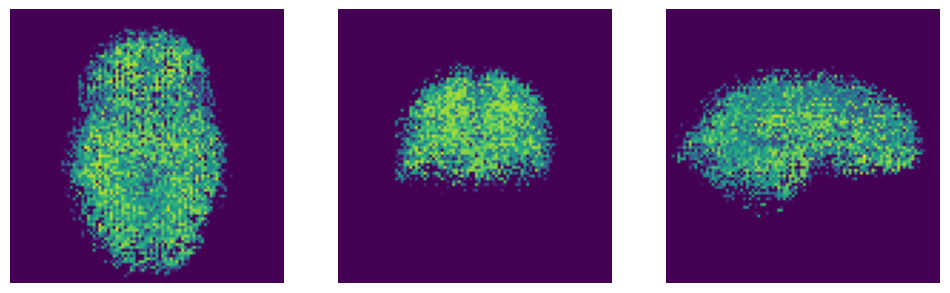

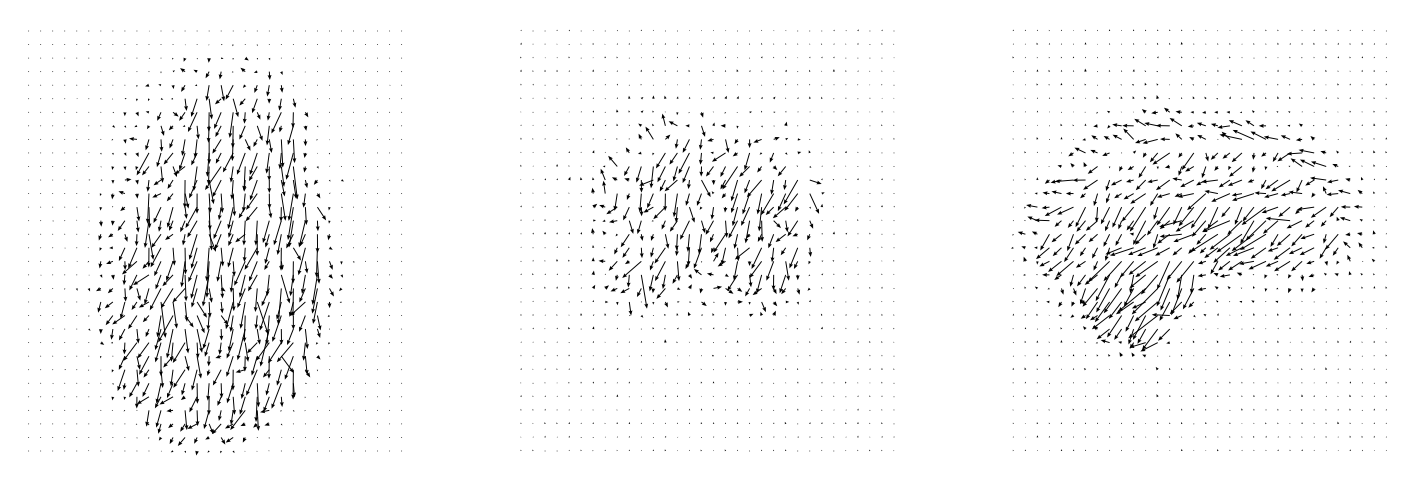

In [ ]:
#-------------------------------------------------------------
#--- PERFORMING IMAGE WARPING
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- PERFORMING IMAGE WARPING")
print("#-------------------------------------------------------------\n")

# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp( ############## YO WARP PACHI NI USE HUNXA
    mode="bilinear", 
    padding_mode="border",
)
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item["img12"][[1], :, :, :].unsqueeze(0), reg_net_example_output  # moving image  # warping
)

# Previewing warped image
preview_image(example_warped_image[0,0].detach())

# Previewing displacement field
preview_3D_vector_field(reg_net_example_output.detach()[0])

In [ ]:
#-------------------------------------------------------------
#--- INITIALIZING A SWAP FUNCTION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- INITIALIZING A SWAP FUNCTION")
print("#-------------------------------------------------------------\n")

# While training for one network we dont want to computer gradients for the other network
def swap_training(network_to_train, network_to_not_train):
    """
    Switch out of training one network and into training another
    """
    for param in network_to_not_train.parameters():
        param.requires_grad = False

    for param in network_to_train.parameters():
        param.requires_grad = True

    network_to_not_train.eval()
    network_to_train.train()


#-------------------------------------------------------------
#--- INITIALIZING A SWAP FUNCTION
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- INITIALIZING DATALOADER")
print("#-------------------------------------------------------------\n")

# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability: (
        monai.data.DataLoader(
            dataset, 
            batch_size=2, 
            num_workers=0, 
            shuffle=True,
        ) 
        if len(dataset) > 0 
        else [] # Number of workers can be set to 4 for better performance
    )  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability: (
        monai.data.DataLoader(
            dataset,
            batch_size=4,
            num_workers=0, # 4
            shuffle=True,  # Shuffle validation data because we will only take a sample for validation each time
        )
        if len(dataset) > 0
        else []
    )  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- REGISTRATION LOSS FUNCTIONS
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- REGISTRATION LOSS FUNCTIONS")
print("#-------------------------------------------------------------\n")

lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=3, kernel_type="rectangular", reduction="mean"
)

# Uncomment to try out the image similarity loss on the example.
lncc_loss(
    example_warped_image, # registered image
    data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
)

bending_loss = monai.losses.BendingEnergyLoss()
# Uncomment to try out the bending energy loss on the example
bending_loss(reg_net_example_output)

regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D)."""
    warped_img2 = warp(image_pair[:, [1], :, :, :], displacement_field)
    return lncc_loss(warped_img2, image_pair[:, [0], :, :, :])  # prediction  # target

def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1=None, gt_seg2=None):
    """
    Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D).
    seg_net is the model used to segment an image,
      mapping (B,1,H,W,D) to (B,C,H,W,D) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,H,W,D).
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(gt_seg1, num_segmentation_classes)
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:, [0], :, :, :]).softmax(dim=1)

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(gt_seg2, num_segmentation_classes)
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:, [1], :, :, :]).softmax(dim=1)

    # seg1 and seg2 are now in the form of class probabilities at each voxel
    # The trilinear interpolation of the function `warp` is then safe to use;
    # it will preserve the probabilistic interpretation of seg2.

    return dice_loss2(
        warp(seg2, displacement_field), seg1  # warp of moving image segmentation  # target image segmentation
    )

def reg_losses(batch):
    img12 = batch["img12"].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch["seg1"].to(device) if "seg1" in batch.keys() else None
    gt_seg2 = batch["seg2"].to(device) if "seg2" in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana


#-------------------------------------------------------------
#--- REGISTRATION LOSS FUNCTIONS
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- DEFINING BATCH GENERATOR
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- DEFINING BATCH GENERATOR")
print("#-------------------------------------------------------------\n")

seg_availabilities = ["00", "01", "10", "11"]


def create_batch_generator(dataloader_subdivided, weights=None):
    """
    Create a batch generator that samples data pairs with various segmentation availabilities.

    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets

    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s: iter(d) for s, d in dataloader_subdivided.items()}

    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration:  # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] = iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])

    return batch_generator

batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)

#-------------------------------------------------------------
#--- DEFINING BATCH GENERATOR
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- SEG INFO
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- SEG INFO")
print("#-------------------------------------------------------------\n")

# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0] + [len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(
    f"""When training seg_net alone, segmentation availabilities {seg_availabilities}
will be sampled with respective weights {seg_train_sampling_weights}"""
)
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

#-------------------------------------------------------------
#--- SEG INFO
#-------------------------------------------------------------

When training seg_net alone, segmentation availabilities ['00', '01', '10', '11']
will be sampled with respective weights [0, 20, 20, 28]


# Check_1

Training dsc na badne code yehai yo

In [ ]:
# #-------------------------------------------------------------
# #--- TRAINING WITH ORG MODEL
# #-------------------------------------------------------------

# print("#-------------------------------------------------------------")
# print("#--- TRAINING")
# print("#-------------------------------------------------------------\n")

# # ----------------------------
# # 1. Model Preparation
# # ----------------------------

# seg_net.to(device)  # Moves the segmentation model to GPU (or CPU depending on 'device')
# reg_net.to(device)  # Moves the registration model to GPU/CPU

# # ----------------------------
# # 2. Define Optimizers
# # ----------------------------

# learning_rate_reg = 5e-4
# optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

# learning_rate_seg = 1e-3
# optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

# # ----------------------------
# # 3. Define Loss Weights
# # ----------------------------

# lambda_a = 2.0  # anatomy loss weight
# lambda_sp = 3.0  # supervised segmentation loss weight

# # Regularization loss weight
# # Bending energy (smoothness regularization) weight, depends on image size
# lambda_r = 7.5 * (image_scale / 128) ** 2

# # ----------------------------
# # 4. Training Parameters
# # ----------------------------

# max_epochs = 5 # 120 (set low here for debugging)
# reg_phase_training_batches_per_epoch = 5 # Training iterations for reg_net 
# seg_phase_training_batches_per_epoch = 1 # Training iterations for seg_net
# reg_phase_num_validation_batches_to_use = 5 # Batches used for validation of reg_net
# val_interval = 1 # Run validation after every epoch

# # Lists to store training and validation losses and metrics
# training_losses_reg = []
# validation_losses_reg = []
# training_losses_seg = []
# validation_losses_seg = []
# training_dices = []
# validation_dices = []
# # For saving the best model
# best_seg_validation_loss = float("inf")
# best_reg_validation_loss = float("inf")

# # ----------------------------
# # 5. Training Loop
# # ----------------------------

# for epoch_number in range(max_epochs):
#     print(f"Epoch {epoch_number+1}/{max_epochs}:")

#     #------------------------------------------------
#     # --- Training Registration Network (reg_net) ---
#     # ------------------------------------------------
#     #         reg_net training, with seg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
#     swap_training(reg_net, seg_net) # Enables training for reg_net, disables seg_net

#     losses = []
#     for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
#         optimizer_reg.zero_grad()   # Reset gradients
#         loss_sim, loss_reg, loss_ana = reg_losses(batch) # Compute losses
#         loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana # Combine with weights
#         loss.backward() # Backpropagation
#         optimizer_reg.step() # Update model weights
#         losses.append(loss.item()) # Store total loss

#     training_loss = np.mean(losses)
#     print(f"\treg training loss: {training_loss}")
#     training_losses_reg.append([epoch_number, training_loss])

#     # --- Validation of reg_net ---

#     if epoch_number % val_interval == 0:
#         reg_net.eval()  # Switch to eval mode
#         losses = []
#         with torch.no_grad():   # No gradient calculation
#             for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
#                 loss_sim, loss_reg, loss_ana = reg_losses(batch)
#                 loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\treg validation loss: {validation_loss}")
#         validation_losses_reg.append([epoch_number, validation_loss])

#         # Save best model
#         if validation_loss < best_reg_validation_loss:
#             best_reg_validation_loss = validation_loss
#             torch.save(reg_net.state_dict(), "reg_net_best.pth")

#     # Free up memory
#     del loss, loss_sim, loss_reg, loss_ana
#     torch.cuda.empty_cache()

#     # -----------------------------------------------
#     # --- Training Segmentation Network (seg_net) ---
#     # ------------------------------------------------
#     #         seg_net training, with reg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
#     swap_training(seg_net, reg_net) # Enables training for seg_net, disables reg_net
    
#     dice_metric.reset()
#     losses = []
#     for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
#         optimizer_seg.zero_grad()

#         img12 = batch["img12"].to(device) # Get image pair

#         displacement_fields = reg_net(img12) # Predict deformation fields
#         seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1) # Segment image 1
#         seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1) # Segment image 2

#         # Below we compute the following:
#         # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
#         # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
#         # loss_metric: a single supervised seg loss, as a metric to track the progress of training
#         # Handle segmentation loss
#         if "seg1" in batch.keys() and "seg2" in batch.keys():
#             seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes) # Same one hot encoding ho but with full path
#             seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
#             # The above supervised loss looks a bit different from the one in the paper
#             # in that it includes predictions for both images in the current image pair;
#             # we might as well do this, since we have gone to the trouble of loading
#             # both segmentations into memory.
            
#             # # Track classes present in seg1
#             # presence_seg1 = (seg1.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg1 batch: {presence_seg1}")
#             # presence_seg2 = (seg2.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg2 batch: {presence_seg2}")

#             # print("--------------------111-------------------------")
#             # print(seg1_predicted.shape)
#             # print(seg1.shape)
#             # print(seg2_predicted.shape)
#             # print(seg2.shape)        
#             # print("---------------------------------------------")    
#             # Update DSC metric for seg1 and seg2 (dice_metric(preds, labels))
#             count = 1

#         elif "seg1" in batch.keys():  # seg1 available, but no seg2
#             seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg1_predicted, seg1)
#             loss_supervised = loss_metric
#             seg2 = seg2_predicted  # Use this in anatomy loss
            
#             # # Track class presence
#             # presence_seg1 = (seg1.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg1 batch: {presence_seg1}")

#             # print("--------------------222-------------------------")
#             # print(seg1_predicted.shape)
#             # print(seg1.shape)
#             # print(seg2_predicted.shape)
#             # print(seg2.shape)        
#             # print("---------------------------------------------")  
#             # Update DSC metric for seg1 only
#             count = 2

#         else:  # seg2 available, but no seg1
#             assert "seg2" in batch.keys()
#             seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = loss_metric
#             seg1 = seg1_predicted  # Use this in anatomy loss

#             # # Track Class presence
#             # presence_seg2 = (seg2.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg2 batch: {presence_seg2}")
#             # # Update DSC metric for seg2 only
#             # print("--------------------333-------------------------")
#             # print(seg1_predicted.shape)
#             # print(seg1.shape)
#             # print(seg2_predicted.shape)
#             # print(seg2.shape)        
#             # print("---------------------------------------------")  
#             count = 3

#         # seg1 and seg2 should now be in the form of one-hot class probabilities

#         # Compute anatomy loss: warp seg2 to seg1 space
#         loss_anatomy = (
#             dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
#             if "seg1" in batch.keys() or "seg2" in batch.keys()
#             else 0.0
#         )  # It wouldn't really be 0, but it would not contribute to training seg_net

#         # (If you want to refactor this code for *joint* training of reg_net and seg_net,
#         #  then use the definition of anatomy loss given in the function anatomy_loss above,
#         #  where differentiable warping is used and reg net can be trained with it.)

#         loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
#         loss.backward()
#         optimizer_seg.step()
#         losses.append(loss_metric.item())
#         with torch.no_grad():
#             if count == 1:
#                 print(f"seg1_predicted: {count} {seg1_predicted.shape} seg1 {seg1.shape}")
#                 print(f"seg1_predicted: {count} {seg2_predicted.shape} seg1 {seg2.shape}")
#                 dice_metric(seg1_predicted, seg1)
#                 dice_metric(seg2_predicted, seg2)
#                 count = 0
#             elif count == 2:
#                 print(f"seg1_predicted: {count} {seg1_predicted.shape} seg1 {seg1.shape}")
#                 dice_metric(seg1_predicted, seg1)
#                 count = 0
#             elif count == 3:
#                 print(f"seg1_predicted: {count} {seg2_predicted.shape} seg1 {seg2.shape}")
#                 dice_metric(seg2_predicted, seg2)
#                 count = 0
#             else:
#                 print(" ERROR ")
#                 break

#     training_loss = np.mean(losses)
#     print(f"\tseg training loss: {training_loss}")
#     training_losses_seg.append([epoch_number,training_loss])
#     # DSC ADD
#     dice_scores, _ = dice_metric.aggregate()
#     dice_metric.reset()
#     training_dice = dice_scores.mean().item()
#     print(f"\ttraining DSC: {training_dice:.4f}")
#     training_dices.append([epoch_number, training_dice])

#     # --- Validation of seg_net ---

#     if epoch_number % val_interval == 0:
#         # The following validation loop would not do anything in the case
#         # where there is just one segmentation available,
#         # because data_seg_available_valid would be empty.
#         seg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in dataloader_seg_available_valid:
#                 imgs = batch["img"].to(device)
#                 true_segs = batch["seg"].to(device) # shape: [B, 1, D, H, W]
#                 predicted_segs = seg_net(imgs)
#                 loss = dice_loss(predicted_segs, true_segs)
#                 losses.append(loss.item())
#                 # DSC ADDED
#                 pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_segmentation_classes)
#                 true_onehot = one_hot(true_segs, num_classes=num_segmentation_classes)
#                 print(f"predicted_segs: {pred_onehot.shape} true_segs {true_onehot.shape}")
#                 dice_metric(pred_onehot, true_onehot)


#         validation_loss = np.mean(losses)
#         print(f"\tseg validation loss: {validation_loss}")
#         validation_losses_seg.append([epoch_number, validation_loss])

#         # After training loop: aggregate and reset DSC
#         dice_scores, _ = dice_metric.aggregate()
#         dice_metric.reset()
#         validation_dice = dice_scores.mean().item()
#         print(f"\tvalidation DSC: {validation_dice:.4f}")
#         validation_dices.append([epoch_number, validation_dice])

#         if validation_loss < best_seg_validation_loss:
#             best_seg_validation_loss = validation_loss
#             torch.save(seg_net.state_dict(), "seg_net_best.pth")

#     # Free up memory
#     del (
#         loss,
#         seg1,
#         seg2,
#         displacement_fields,
#         img12,
#         loss_supervised,
#         loss_anatomy,
#         loss_metric,
#         seg1_predicted,
#         seg2_predicted,
#     )
#     torch.cuda.empty_cache()

# print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
# print(f"Best seg_net validation loss: {best_seg_validation_loss}")
# exit()

# '''
# monai ko loss function i.e. dice loss does not expect one hot
# monai ko evaluation metric dice metric expects one hot
# '''

#-------------------------------------------------------------
#--- TRAINING
#-------------------------------------------------------------

Epoch 1/5:
	reg training loss: 12.094528961181641
	reg validation loss: -138.1460823535919
seg1_predicted: 1 torch.Size([2, 4, 96, 96, 96]) seg1 torch.Size([2, 4, 96, 96, 96])
seg1_predicted: 1 torch.Size([2, 4, 96, 96, 96]) seg1 torch.Size([2, 4, 96, 96, 96])
	seg training loss: 0.7043248414993286
	training DSC: 0.2945
predicted_segs: torch.Size([2, 4, 96, 96, 96]) true_segs torch.Size([2, 4, 96, 96, 96])
	seg validation loss: 0.70915687084198
	validation DSC: 0.4484
Epoch 2/5:
	reg training loss: 6.089103317260742
	reg validation loss: -82.49781761169433
seg1_predicted: 1 torch.Size([2, 4, 96, 96, 96]) seg1 torch.Size([2, 4, 96, 96, 96])
seg1_predicted: 1 torch.Size([2, 4, 96, 96, 96]) seg1 torch.Size([2, 4, 96, 96, 96])
	seg training loss: 0.7219698429107666
	training DSC: 0.2894
predicted_segs: torch.Size([2, 4, 96, 96, 96]) true_segs torch.Si

KeyboardInterrupt: 

# Check_2

Training and val dsc na badne code yehai ho

In [ ]:
# #-------------------------------------------------------------
# #--- TRAINING WITH REF TO ONLY SEG NET
# #-------------------------------------------------------------

# print("#-------------------------------------------------------------")
# print("#--- TRAINING")
# print("#-------------------------------------------------------------\n")

# # ----------------------------
# # 1. Model Preparation
# # ----------------------------

# seg_net.to(device)  # Moves the segmentation model to GPU (or CPU depending on 'device')
# reg_net.to(device)  # Moves the registration model to GPU/CPU

# # ----------------------------
# # 2. Define Optimizers
# # ----------------------------

# learning_rate_reg = 5e-4
# optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

# learning_rate_seg = 1e-3
# optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

# # ----------------------------
# # 3. Define Loss Weights
# # ----------------------------

# lambda_a = 2.0  # anatomy loss weight
# lambda_sp = 3.0  # supervised segmentation loss weight

# # Regularization loss weight
# # Bending energy (smoothness regularization) weight, depends on image size
# lambda_r = 7.5 * (image_scale / 128) ** 2

# # ----------------------------
# # 4. Training Parameters
# # ----------------------------

# num_segmentation_classes = 4
# max_epochs = 2 # 120 (set low here for debugging)
# reg_phase_training_batches_per_epoch = 5 # Training iterations for reg_net 
# seg_phase_training_batches_per_epoch = 1 # Training iterations for seg_net
# reg_phase_num_validation_batches_to_use = 5 # Batches used for validation of reg_net
# val_interval = 1 # Run validation after every epoch

# # Lists to store training and validation losses and metrics
# training_losses_reg = []
# validation_losses_reg = []
# training_losses_seg = []
# validation_losses_seg = []
# training_dices = []
# validation_dices = []
# # dice_scores_train = []
# # dice_scores_val = []
# # dice_scores_train_per_class = []
# # dice_scores_val_per_class = []

# # For saving the best model
# best_seg_validation_loss = float("inf")
# best_reg_validation_loss = float("inf")

# # ----------------------------
# # 5. Training Loop
# # ----------------------------

# for epoch_number in range(max_epochs):
#     print(f"Epoch {epoch_number+1}/{max_epochs}:")

#     #------------------------------------------------
#     # --- Training Registration Network (reg_net) ---
#     # ------------------------------------------------
#     #         reg_net training, with seg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
#     swap_training(reg_net, seg_net) # Enables training for reg_net, disables seg_net

#     losses = []
#     for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
#         optimizer_reg.zero_grad()   # Reset gradients
#         loss_sim, loss_reg, loss_ana = reg_losses(batch) # Compute losses
#         loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana # Combine with weights
#         loss.backward() # Backpropagation
#         optimizer_reg.step() # Update model weights
#         losses.append(loss.item()) # Store total loss

#     training_loss = np.mean(losses)
#     print(f"\treg training loss: {training_loss}")
#     training_losses_reg.append([epoch_number, training_loss])

#     # --- Validation of reg_net ---

#     if epoch_number % val_interval == 0:
#         reg_net.eval()  # Switch to eval mode
#         losses = []
#         with torch.no_grad():   # No gradient calculation
#             for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
#                 loss_sim, loss_reg, loss_ana = reg_losses(batch)
#                 loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\treg validation loss: {validation_loss}")
#         validation_losses_reg.append([epoch_number, validation_loss])

#         # Save best model
#         if validation_loss < best_reg_validation_loss:
#             best_reg_validation_loss = validation_loss
#             torch.save(reg_net.state_dict(), "reg_net_best.pth")

#     # Free up memory
#     del loss, loss_sim, loss_reg, loss_ana
#     torch.cuda.empty_cache()

#     # -----------------------------------------------
#     # --- Training Segmentation Network (seg_net) ---
#     # ------------------------------------------------
#     #         seg_net training, with reg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
#     swap_training(seg_net, reg_net) # Enables training for seg_net, disables reg_net
#     dice_metric.reset()

#     losses = []
#     for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
#         optimizer_seg.zero_grad()

#         img12 = batch["img12"].to(device) # Get image pair

#         displacement_fields = reg_net(img12) # Predict deformation fields
#         seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1) # Segment image 1
#         seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1) # Segment image 2

#         # Below we compute the following:
#         # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
#         # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
#         # loss_metric: a single supervised seg loss, as a metric to track the progress of training
#         # Handle segmentation loss
#         if "seg1" in batch.keys() and "seg2" in batch.keys():
#             seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes) # Same one hot encoding ho but with full path
#             seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
#             # The above supervised loss looks a bit different from the one in the paper
#             # in that it includes predictions for both images in the current image pair;
#             # we might as well do this, since we have gone to the trouble of loading
#             # both segmentations into memory.
            
#             # # Track classes present in seg1
#             # presence_seg1 = (seg1.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg1 batch: {presence_seg1}")
#             # presence_seg2 = (seg2.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg2 batch: {presence_seg2}")

#             # print("--------------------111-------------------------")
#             # print(seg1_predicted.shape)
#             # print(seg1.shape)
#             # print(seg2_predicted.shape)
#             # print(seg2.shape)        
#             # print("---------------------------------------------")    
#             # Update DSC metric for seg1 and seg2 (dice_metric(preds, labels))
#             count = 1

#         elif "seg1" in batch.keys():  # seg1 available, but no seg2
#             seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg1_predicted, seg1)
#             loss_supervised = loss_metric
#             seg2 = seg2_predicted  # Use this in anatomy loss
            
#             # # Track class presence
#             # presence_seg1 = (seg1.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg1 batch: {presence_seg1}")

#             # print("--------------------222-------------------------")
#             # print(seg1_predicted.shape)
#             # print(seg1.shape)
#             # print(seg2_predicted.shape)
#             # print(seg2.shape)        
#             # print("---------------------------------------------")  
#             # Update DSC metric for seg1 only
#             count = 2

#         else:  # seg2 available, but no seg1
#             assert "seg2" in batch.keys()
#             seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = loss_metric
#             seg1 = seg1_predicted  # Use this in anatomy loss

#             # # Track Class presence
#             # presence_seg2 = (seg2.sum(dim=[0,2,3,4]) > 0).cpu().numpy().tolist()
#             # print(f"Classes present in seg2 batch: {presence_seg2}")
#             # # Update DSC metric for seg2 only
#             # print("--------------------333-------------------------")
#             # print(seg1_predicted.shape)
#             # print(seg1.shape)
#             # print(seg2_predicted.shape)
#             # print(seg2.shape)        
#             # print("---------------------------------------------")  
#             count = 3

#         # seg1 and seg2 should now be in the form of one-hot class probabilities

#         # Compute anatomy loss: warp seg2 to seg1 space
#         loss_anatomy = (
#             dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
#             if "seg1" in batch.keys() or "seg2" in batch.keys()
#             else 0.0
#         )  # It wouldn't really be 0, but it would not contribute to training seg_net

#         # (If you want to refactor this code for *joint* training of reg_net and seg_net,
#         #  then use the definition of anatomy loss given in the function anatomy_loss above,
#         #  where differentiable warping is used and reg net can be trained with it.)

#         loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
#         loss.backward()
#         optimizer_seg.step()
#         losses.append(loss_metric.item())
#         if count == 1:
#             dice_metric(seg1_predicted, seg1)
#             dice_metric(seg2_predicted, seg2)
#             count = 0
#         elif count == 2:
#             dice_metric(seg1_predicted, seg1)
#             count = 0
#         elif count == 3:
#             dice_metric(seg2_predicted, seg2)
#             count = 0
#         else:
#             print(" ERROR ")
#             break

#     training_loss = np.mean(losses)
#     print(f"\tseg training loss: {training_loss}")
#     training_losses_seg.append([epoch_number,training_loss])
#     dice_scores, _ = dice_metric.aggregate()
#     dice_metric.reset()
#     training_dice = dice_scores.mean().item()
#     print(f"\ttraining DSC: {training_dice:.4f}")
#     training_dices.append([epoch_number, training_dice])

#     # --- Validation of seg_net ---

#     if epoch_number % val_interval == 0:
#         # The following validation loop would not do anything in the case
#         # where there is just one segmentation available,
#         # because data_seg_available_valid would be empty.
#         seg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in dataloader_seg_available_valid:
#                 imgs = batch["img"].to(device)
#                 true_segs = batch["seg"].to(device) # shape: [B, 1, D, H, W]
#                 predicted_segs = seg_net(imgs)
#                 loss = dice_loss(predicted_segs, true_segs)
#                 losses.append(loss.item())
#                 dice_metric(predicted_segs, true_segs)

#         validation_loss = np.mean(losses)
#         print(f"\tseg validation loss: {validation_loss}")
#         validation_losses.append([epoch_number, validation_loss])

#         # After training loop: aggregate and reset DSC
#         dice_scores, _ = dice_metric.aggregate()
#         dice_metric.reset()
#         validation_dice = dice_scores.mean().item()
#         print(f"\tvalidation DSC: {validation_dice:.4f}")
#         validation_dices.append([epoch_number, validation_dice])

#         if validation_loss < best_seg_validation_loss:
#             best_seg_validation_loss = validation_loss
#             torch.save(seg_net.state_dict(), "seg_net_best.pth")

#     # Free up memory
#     del (
#         loss,
#         seg1,
#         seg2,
#         displacement_fields,
#         img12,
#         loss_supervised,
#         loss_anatomy,
#         loss_metric,
#         seg1_predicted,
#         seg2_predicted,
#     )
#     torch.cuda.empty_cache()

# print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
# print(f"Best seg_net validation loss: {best_seg_validation_loss}")

# '''
# monai ko loss function i.e. dice loss does not expect one hot
# monai ko evaluation metric dice metric expects one hot
# '''

# ORG

Training and Val DSC na vayeko ra sab chalne code

In [ ]:
# # Training cell
# # (if already done then you may skip this and uncomment the loading checkpoint cell below)

# seg_net.to(device)
# reg_net.to(device)

# learning_rate_reg = 5e-4
# optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

# learning_rate_seg = 1e-3
# optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

# lambda_a = 2.0  # anatomy loss weight
# lambda_sp = 3.0  # supervised segmentation loss weight

# # regularization loss weight
# # This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# # depend on image scale. This is because the bending energy loss is not scale-invariant.
# # 7.5 worked well with the above hyperparameters for images of size 128x128x128.
# lambda_r = 7.5 * (image_scale / 128) ** 2

# max_epochs = 10 # 120
# reg_phase_training_batches_per_epoch = 5 #40 
# seg_phase_training_batches_per_epoch = 1 #5  # Fewer batches needed, because seg_net converges more quickly
# reg_phase_num_validation_batches_to_use = 5 #40
# val_interval = 1 # 5

# training_losses_reg = []
# validation_losses_reg = []
# training_losses_seg = []
# validation_losses_seg = []

# best_seg_validation_loss = float("inf")
# best_reg_validation_loss = float("inf")

# for epoch_number in range(max_epochs):
#     print(f"Epoch {epoch_number+1}/{max_epochs}:")

#     # ------------------------------------------------
#     #         reg_net training, with seg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
#     swap_training(reg_net, seg_net)

#     losses = []
#     for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
#         optimizer_reg.zero_grad()
#         loss_sim, loss_reg, loss_ana = reg_losses(batch)
#         loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#         loss.backward()
#         optimizer_reg.step()
#         losses.append(loss.item())

#     training_loss = np.mean(losses)
#     print(f"\treg training loss: {training_loss}")
#     training_losses_reg.append([epoch_number, training_loss])

#     if epoch_number % val_interval == 0:
#         reg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
#                 loss_sim, loss_reg, loss_ana = reg_losses(batch)
#                 loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\treg validation loss: {validation_loss}")
#         validation_losses_reg.append([epoch_number, validation_loss])

#         if validation_loss < best_reg_validation_loss:
#             best_reg_validation_loss = validation_loss
#             torch.save(reg_net.state_dict(), "reg_net_best.pth")

#     # Free up memory
#     del loss, loss_sim, loss_reg, loss_ana
#     torch.cuda.empty_cache()

#     # ------------------------------------------------
#     #         seg_net training, with reg_net frozen
#     # ------------------------------------------------

#     # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
#     swap_training(seg_net, reg_net)

#     losses = []
#     for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
#         optimizer_seg.zero_grad()

#         img12 = batch["img12"].to(device)

#         displacement_fields = reg_net(img12)
#         seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1)
#         seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1)

#         # Below we compute the following:
#         # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
#         # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
#         # loss_metric: a single supervised seg loss, as a metric to track the progress of training

#         if "seg1" in batch.keys() and "seg2" in batch.keys():
#             seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
#             seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
#             # The above supervised loss looks a bit different from the one in the paper
#             # in that it includes predictions for both images in the current image pair;
#             # we might as well do this, since we have gone to the trouble of loading
#             # both segmentations into memory.

#         elif "seg1" in batch.keys():  # seg1 available, but no seg2
#             seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg1_predicted, seg1)
#             loss_supervised = loss_metric
#             seg2 = seg2_predicted  # Use this in anatomy loss

#         else:  # seg2 available, but no seg1
#             assert "seg2" in batch.keys()
#             seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
#             loss_metric = dice_loss2(seg2_predicted, seg2)
#             loss_supervised = loss_metric
#             seg1 = seg1_predicted  # Use this in anatomy loss

#         # seg1 and seg2 should now be in the form of one-hot class probabilities

#         loss_anatomy = (
#             dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
#             if "seg1" in batch.keys() or "seg2" in batch.keys()
#             else 0.0
#         )  # It wouldn't really be 0, but it would not contribute to training seg_net

#         # (If you want to refactor this code for *joint* training of reg_net and seg_net,
#         #  then use the definition of anatomy loss given in the function anatomy_loss above,
#         #  where differentiable warping is used and reg net can be trained with it.)

#         loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
#         loss.backward()
#         optimizer_seg.step()

#         losses.append(loss_metric.item())

#     training_loss = np.mean(losses)
#     print(f"\tseg training loss: {training_loss}")
#     training_losses_seg.append([epoch_number, training_loss])

#     if epoch_number % val_interval == 0:
#         # The following validation loop would not do anything in the case
#         # where there is just one segmentation available,
#         # because data_seg_available_valid would be empty.
#         seg_net.eval()
#         losses = []
#         with torch.no_grad():
#             for batch in dataloader_seg_available_valid:
#                 imgs = batch["img"].to(device)
#                 true_segs = batch["seg"].to(device)
#                 predicted_segs = seg_net(imgs)
#                 loss = dice_loss(predicted_segs, true_segs)
#                 losses.append(loss.item())

#         validation_loss = np.mean(losses)
#         print(f"\tseg validation loss: {validation_loss}")
#         validation_losses_seg.append([epoch_number, validation_loss])

#         if validation_loss < best_seg_validation_loss:
#             best_seg_validation_loss = validation_loss
#             torch.save(seg_net.state_dict(), "seg_net_best.pth")

#     # Free up memory
#     del (
#         loss,
#         seg1,
#         seg2,
#         displacement_fields,
#         img12,
#         loss_supervised,
#         loss_anatomy,
#         loss_metric,
#         seg1_predicted,
#         seg2_predicted,
#     )
#     torch.cuda.empty_cache()

# print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
# print(f"Best seg_net validation loss: {best_seg_validation_loss}")

# DSC add garne kasari

In [ ]:
# Training cell
# (if already done then you may skip this and uncomment the loading checkpoint cell below)

seg_net.to(device)
reg_net.to(device)

learning_rate_reg = 5e-4
optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

learning_rate_seg = 1e-3
optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

lambda_a = 2.0  # anatomy loss weight
lambda_sp = 3.0  # supervised segmentation loss weight

# regularization loss weight
# This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# depend on image scale. This is because the bending energy loss is not scale-invariant.
# 7.5 worked well with the above hyperparameters for images of size 128x128x128.
lambda_r = 7.5 * (image_scale / 128) ** 2

max_epochs = 10 # 120
reg_phase_training_batches_per_epoch = 5 #40 
seg_phase_training_batches_per_epoch = 1 #5  # Fewer batches needed, because seg_net converges more quickly
reg_phase_num_validation_batches_to_use = 5 #40
val_interval = 1 # 5

training_losses_reg = []
validation_losses_reg = []
training_losses_seg = []
validation_losses_seg = []

best_seg_validation_loss = float("inf")
best_reg_validation_loss = float("inf")

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    # ------------------------------------------------
    #         reg_net training, with seg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
    swap_training(reg_net, seg_net)

    losses = []
    for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
        optimizer_reg.zero_grad()
        loss_sim, loss_reg, loss_ana = reg_losses(batch)
        loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
        loss.backward()
        optimizer_reg.step()
        losses.append(loss.item())

    training_loss = np.mean(losses)
    print(f"\treg training loss: {training_loss}")
    training_losses_reg.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        reg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
                loss_sim, loss_reg, loss_ana = reg_losses(batch)
                loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\treg validation loss: {validation_loss}")
        validation_losses_reg.append([epoch_number, validation_loss])

        if validation_loss < best_reg_validation_loss:
            best_reg_validation_loss = validation_loss
            torch.save(reg_net.state_dict(), "reg_net_best.pth")

    # Free up memory
    del loss, loss_sim, loss_reg, loss_ana
    torch.cuda.empty_cache()

    # ------------------------------------------------
    #         seg_net training, with reg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
    swap_training(seg_net, reg_net)

    losses = []
    for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
        optimizer_seg.zero_grad()

        img12 = batch["img12"].to(device)

        displacement_fields = reg_net(img12)
        seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1)
        seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1)

        # Below we compute the following:
        # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
        # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
        # loss_metric: a single supervised seg loss, as a metric to track the progress of training

        if "seg1" in batch.keys() and "seg2" in batch.keys():
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
            print(f"seg2 : {seg2.shape} seg2_predicted: {seg2_predicted.shape}")
            print(f"seg1 : {seg1.shape} seg1_predicted: {seg1_predicted.shape}")

            # The above supervised loss looks a bit different from the one in the paper
            # in that it includes predictions for both images in the current image pair;
            # we might as well do this, since we have gone to the trouble of loading
            # both segmentations into memory.

        elif "seg1" in batch.keys():  # seg1 available, but no seg2
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg1_predicted, seg1)
            loss_supervised = loss_metric
            seg2 = seg2_predicted  # Use this in anatomy loss
            print(f"seg1 : {seg1.shape} seg1_predicted: {seg1_predicted.shape}")


        else:  # seg2 available, but no seg1
            assert "seg2" in batch.keys()
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = loss_metric
            seg1 = seg1_predicted  # Use this in anatomy loss
            print(f"seg2 : {seg2.shape} seg2_predicted: {seg2_predicted.shape}")


        # seg1 and seg2 should now be in the form of one-hot class probabilities

        loss_anatomy = (
            dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
            if "seg1" in batch.keys() or "seg2" in batch.keys()
            else 0.0
        )  # It wouldn't really be 0, but it would not contribute to training seg_net

        # (If you want to refactor this code for *joint* training of reg_net and seg_net,
        #  then use the definition of anatomy loss given in the function anatomy_loss above,
        #  where differentiable warping is used and reg net can be trained with it.)

        loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
        loss.backward()
        optimizer_seg.step()
        # ADDED BY MEEEE
        with torch.no_grad():
            if "seg1" in batch.keys():
                pred1_onehot = one_hot(seg1_predicted.argmax(1, keepdim=True), num_segmentation_classes)
                dice_metric2(pred1_onehot, seg1)
            if "seg2" in batch.keys():
                pred2_onehot = one_hot(seg2_predicted.argmax(1, keepdim=True), num_segmentation_classes)
                dice_metric2(pred2_onehot, seg2)
        losses.append(loss_metric.item())

    training_loss = np.mean(losses)
    print(f"\tseg training loss: {training_loss}")
    training_losses_seg.append([epoch_number, training_loss])
    # MEYYY HUUU KONNNNN
    # Aggregate and reset Dice metric
    train_dice_scores, _ = dice_metric2.aggregate()
    dice_metric2.reset()
    train_dsc = train_dice_scores.mean().item()
    print(f"\tTraining DSC: {train_dsc:.4f}")


    if epoch_number % val_interval == 0:
        # The following validation loop would not do anything in the case
        # where there is just one segmentation available,
        # because data_seg_available_valid would be empty.
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg.append([epoch_number, validation_loss])
        # MAA HUU MAAAA YETAAA
        dice_metric2.reset()
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)

                predicted_segs = seg_net(imgs)
                pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_segmentation_classes)
                true_onehot = one_hot(true_segs, num_segmentation_classes)

                dice_metric2(pred_onehot, true_onehot)

        val_dice_scores, _ = dice_metric2.aggregate()
        dice_metric2.reset()
        val_dsc = val_dice_scores.mean().item()
        print(f"\tValidation DSC: {val_dsc:.4f}")

        if validation_loss < best_seg_validation_loss:
            best_seg_validation_loss = validation_loss
            torch.save(seg_net.state_dict(), "seg_net_best.pth")

    # Free up memory
    del (
        loss,
        seg1,
        seg2,
        displacement_fields,
        img12,
        loss_supervised,
        loss_anatomy,
        loss_metric,
        seg1_predicted,
        seg2_predicted,
    )
    torch.cuda.empty_cache()

print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
print(f"Best seg_net validation loss: {best_seg_validation_loss}")

Epoch 1/10:
	reg training loss: 1.2259242534637451
	reg validation loss: -228.75928395986557
seg1 : torch.Size([2, 4, 96, 96, 96]) seg1_predicted: torch.Size([2, 4, 96, 96, 96])
	seg training loss: 0.4838375449180603
	Training DSC: 0.5670
	seg validation loss: 0.567785382270813
	Validation DSC: 0.4399
Epoch 2/10:
	reg training loss: 1.2413394093513488
	reg validation loss: -151.00622712373735
seg2 : torch.Size([2, 4, 96, 96, 96]) seg2_predicted: torch.Size([2, 4, 96, 96, 96])
seg1 : torch.Size([2, 4, 96, 96, 96]) seg1_predicted: torch.Size([2, 4, 96, 96, 96])
	seg training loss: 0.5188398361206055
	Training DSC: 0.5102
	seg validation loss: 0.5048108100891113
	Validation DSC: 0.4919
Epoch 3/10:
	reg training loss: 1.1751613736152648
	reg validation loss: -228.4840101838112
seg2 : torch.Size([2, 4, 96, 96, 96]) seg2_predicted: torch.Size([2, 4, 96, 96, 96])
seg1 : torch.Size([2, 4, 96, 96, 96]) seg1_predicted: torch.Size([2, 4, 96, 96, 96])
	seg training loss: 0.5005632638931274
	Traini